---

# EN2550 2021: Object Counting on a Convey Belt<a href="#EN2550-2021:-Object-Counting-on-a-Convey-Belt" class="anchor-link"></a>
### *Index Number: 180631J*
### *Submitted on: July 5, 2021*

---

In this assignment, you will be counting and tracking the hexagonal nuts
on a moving convey belt.

### Let's first import required libraries<a href="#Let&#39;s-first-import-required-libraries" class="anchor-link"></a>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# magic commands
%config IPCompleter.greedy=True
%config Completer.use_jedi = False
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

### Let's load and visualize the template image and the convey belt snapshot at a given time.<a href="#Let&#39;s-load-and-visualize-the-template-image-and-the-convey-belt-snapshot-at-a-given-time." class="anchor-link">¶</a>


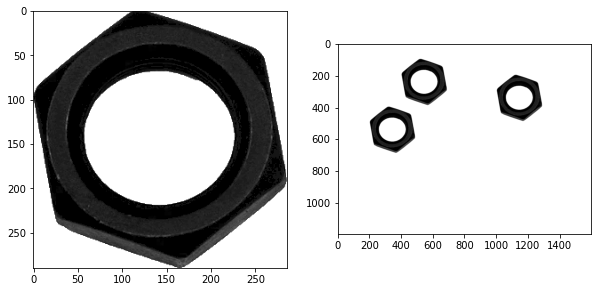

In [2]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im =  cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

## Part-I :<a href="#Part-I-:" class="anchor-link"></a>

Before going into the implementation, let's play with some functions.

### Otsu's thresholding<a href="#Otsu&#39;s-thresholding" class="anchor-link"></a>

* Otsu's method avoids having to choose a value and determines an optimal global threshold value from the image histogram automatically. It is returned as the first output.

Please read
[thresholding](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
to get an idea about different types of thresholding and how to use
them.(Please use **cv.THRESH_BINARY_INV**).

In [3]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
#"< Your code to apply thresholding to the belt_im>"
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) 

### Morphological closing<a href="#Morphological-closing" class="anchor-link"></a>

Carry out morphological closing to remove small holes inside the
foreground. Use a \$3 \\times 3\$ kernel. See
[closing](https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html)
for a guide.

1. Erosion: a pixel element is '1' if all the pixel under the kernel is '1'. So it decreases the white region
2. Dilation: a pixel element is '1' if atleast one pixel under the kernel is '1'. So it increases the white region

In [4]:
#"< 3x3 matrix with all ones, with uint8 dtype>" 
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3)) 
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion
#"< Your code to apply morphological closing for belt >"
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion

### Connected component analysis<a href="#Connected-component-analysis" class="anchor-link"></a>

Apply the `connectedComponentsWithStats` function ([see
this](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga107a78bf7cd25dec05fb4dfc5c9e765f)).



==================Template Image==================
Number of labels:  2


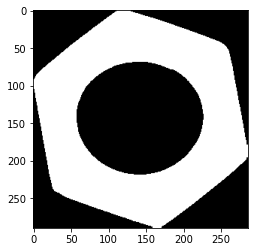

stats: 
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]]
Centroids: 
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]



====================Belt Image====================
Number of labels:  4


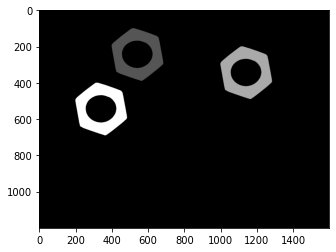

stats: 
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
Centroids: 
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


In [5]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
#"< Your code to perform connected component analysis for closing_b>"
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

print("Template Image".center(50,"="))
print("Number of labels: ", retval_t)
plt.plot(), plt.imshow(labels_t.astype('uint8'), cmap ='gray'), plt.show()
print("stats: \n", stats_t) # stats_t[label,cv.CC_STAT_AREA])
print("Centroids: \n", centroids_t)
print("\n"*2)

print("Belt Image".center(50,"="))
print("Number of labels: ", retval_b)
plt.plot(), plt.imshow(labels_b.astype('uint8'), cmap ='gray'), plt.show()
print("stats: \n", stats_b)
print("Centroids: \n", centroids_b)

-   How many connected components are detected in each image?<br>
Template Image = 2 <br> Belt Image = 4
-   What are the statistics? Interpret these statistics.<br>
Statistics are properties related to each connected component. Statistics object is a 2D array where each column represent a different property related to a given connected component as described below.

**Column 1:** *cv.CC_STAT_LEFT*: the leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.<br>
**Column 2:** *cv.CC_STAT_TOP*: the topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.<br>
**Column 3:** *cv.CC_STAT_WIDTH*: the horizontal size of the bounding box.<br>
**Column 4:** *cv.CC_STAT_HEIGHT*: the vertical size of the bounding box.<br>
**Column 5:** *cv.CC_STAT_AREA*: the total area (in pixels) of the connected component.<br>
-   What are the centroids?<br>
Each row of the 2D Cenroids obejct represents the (x,y) coordinates of centroid of the corresponding connected component.

### Contour analysis<a href="#Contour-analysis" class="anchor-link"></a>

Use `findContours` function to retrieve the *extreme outer* contours.
([see](https://docs.opencv.org/4.5.2/d4/d73/tutorial_py_contours_begin.html)
for help and
[see](https://docs.opencv.org/4.5.2/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)
for information.)

Contours is a Python list of all the contours in the image. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object. Display these countours.

3


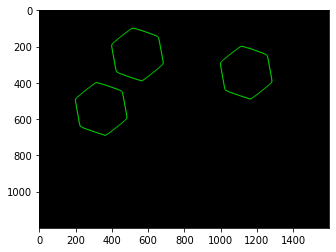

(<matplotlib.image.AxesImage at 0x1d7807f1af0>, None)

In [28]:
# this function has nothing to do with connected components analysis.
# Just use the closed image.

contours_t,_ = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#"< Your code to perform counter analysis for closing_b>"
# cv.RETR_TREE retrieves all of the contours and reconstructs a full hierarchy of nested contours.
contours_b,_ = cv.findContours(closing_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print(len(contours_b))
# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts), plt.show()

### Count the number of matching hexagonal nuts in `belt.png`.<a href="#Count-the-number-of-matching-hexagonal-nuts-in-belt.png." class="anchor-link"></a>

Use the `matchShapes` function as shown in
[examples](https://docs.opencv.org/4.5.2/d5/d45/tutorial_py_contours_more_functions.html)
to match contours in the belt image with that in the template.

Get an idea about the value output by the `cv.matchShapes` when both the
template and the reference image have the same shape. Understand the
given code snippet.<br> 
`cv.matchShapes` enables us to compare two shapes, or two contours and returns a metric showing the similarity. The lower the result, the better match it is. `retval=cv.matchShapes(contour1, contour2, method, parameter)
`

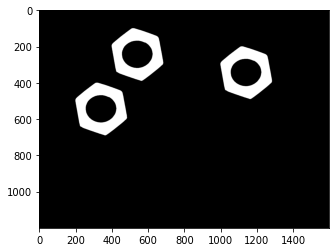

contour  1 --> 0.00010071698397173812
contour  2 --> 0.00010071698397950968
contour  3 --> 0.00010071698397506879


In [7]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')  
plt.imshow(belt, cmap ='gray'),plt.show()
# cv.RETR_EXTERNAL retrieves only the extreme outer contours
belt_cont,_ = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  
for j,c in enumerate(belt_cont):
        print("contour ", j +1,"-->", cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

## Part - II<a href="#Part---II" class="anchor-link"></a>

### Frame tracking through image moments.<a href="#Frame-tracking-through-image-moments." class="anchor-link"></a>

Use the `cv.contourArea()`, see
[this](https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html)
and calculate the the area of the `contours_b[1]`


In [8]:
ca = cv.contourArea(contours_b[1])
print(ca)

60059.5


Use the `cv.moments` to extract the x and y coordinates of the centroid
of `contours_b[1]`.


In [9]:
M = cv.moments(contours_b[1])
print("Area = ", M['m00'])

cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
print("Centroid = ({}, {})".format(cx,cy))

Area =  60059.5
Centroid = (1142, 343)


Make a variable called `count` to represent the number of contours and
set it to the value 1. Make an np array \[cx, cy, ca, count\] and name
this as `object_prev_frame`



In [10]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])

Similarly, you can create the `object_curr_frame`(to describe the
current values) and define the threshold `delta_x` to check whether the
corresponding element of both the `object_curr_frame` and
`object_prev_frame` are less than the `delta_x`. You can set `delta_x`
as 15 or so. (Here the `delta_x` can be thought of as the movement of
the cx from frame to frame)


In [11]:
delta_x = 15

## Part - III<a href="#Part---III" class="anchor-link"></a>

### 1. Implement the function `get_indexed_image`, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)<a href="#1.-Implement-the-function-get_indexed_image,-which-takes-an-image-as-the-input,-performs-thresholding,-closing,-and-connected-component-analysis-and-return-retval,-labels,-stats,-centroids.-(Grading)" class="anchor-link"></a>


In [12]:
def get_indexed_image(im):
    """ Thresholding, closing, and connected component analysis lumped
    """ 

    th, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3)) 
    closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)

    return retval, labels, stats, centroids 

### 2. Implement the function `is_new`, which checks the dissimilarity between 2 vectors. (Grading)<a href="#2.-Implement-the-function-is_new,-which-checks-the-dissimilarity-between-2-vectors.-(Grading)" class="anchor-link"></a>


In [13]:
def is_new(a, b, delta, i):
    """ Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside the tolerances specified in delta. 
    vector i specifies which elements in b to compare with those in a. 
    """    
  
    absolute_different = np.absolute(a - b)
    absolute_different[:,i] = (absolute_different[:,i] > delta[i]) 
    
    'Check whether the absolute different between all the elements of ith column of each array is greater than the ith delta value (See thee example in the next cell)'   
    
    return absolute_different[:,i].all() # all(axis=0) over columns

In [14]:
# check is_new  expected answer False

a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
             [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
             [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

absolute_different = np.absolute(a - b)
print(absolute_different)
absolute_different[:,i] = (absolute_different[:,i] > delta[i])
print(absolute_different)
print(absolute_different[:,i].all()) # all(axis=0) over columns

[[610. 100.  14.   1.]
 [ 10.   0.   0.   2.]
 [801. 210. 120.   0.]]
[[  1. 100.  14.   1.]
 [  0.   0.   0.   2.]
 [  1. 210. 120.   0.]]
False


### 3. If the array `a` is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array `a` is made by stacking all the `object_prev_frame` for each frame. If b is in the form of \[cx, cy, ca, count\], write the function `prev_index` to find the index of a particular nut in the previous frame. (Grading)<a href="#3.-If-the-array-a-is-in-the-shape-of-(number-of-nuts-,-len(object_prev_frame))-(-i.e.-array-a-is-made-by-stacking-all-the-object_prev_frame-for-each-frame.-If-b-is-in-the-form-of-%5Bcx,-cy,-ca,-count%5D,-write-the-function-prev_index-to-find-the-index-of-a-particular-nut-in-the-previous-frame.-(Grading)" class="anchor-link"></a>


In [15]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    absolute_different = np.absolute(a - b)
    absolute_different[:,i] = (absolute_different[:,i] <= delta[i]) 
    index = np.where(absolute_different[:,i])[0] # all(axis=0) over columns
    
    return index    

In [16]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
             [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
             [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

absolute_different = np.absolute(a - b)
print(absolute_different)
absolute_different[:,i] = (absolute_different[:,i] <= delta[i])
print(absolute_different)
index = np.where(absolute_different[:,i])[0]
print(index)

[[610. 100.  14.   1.]
 [ 10.   0.   0.   2.]
 [801. 210. 120.   0.]]
[[  0. 100.  14.   1.]
 [  1.   0.   0.   2.]
 [  0. 210. 120.   0.]]
[1]


In [17]:
print(np.where([0,1,0])[0])

[1]


### Access video frames
You can use following code snippet load and access each frame of a video


In [18]:
frames = []

cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frames.append(frame)
    cv.imshow("Frame", frame)
    if cv.waitKey(1) == ord('q'):  
        break
        
cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


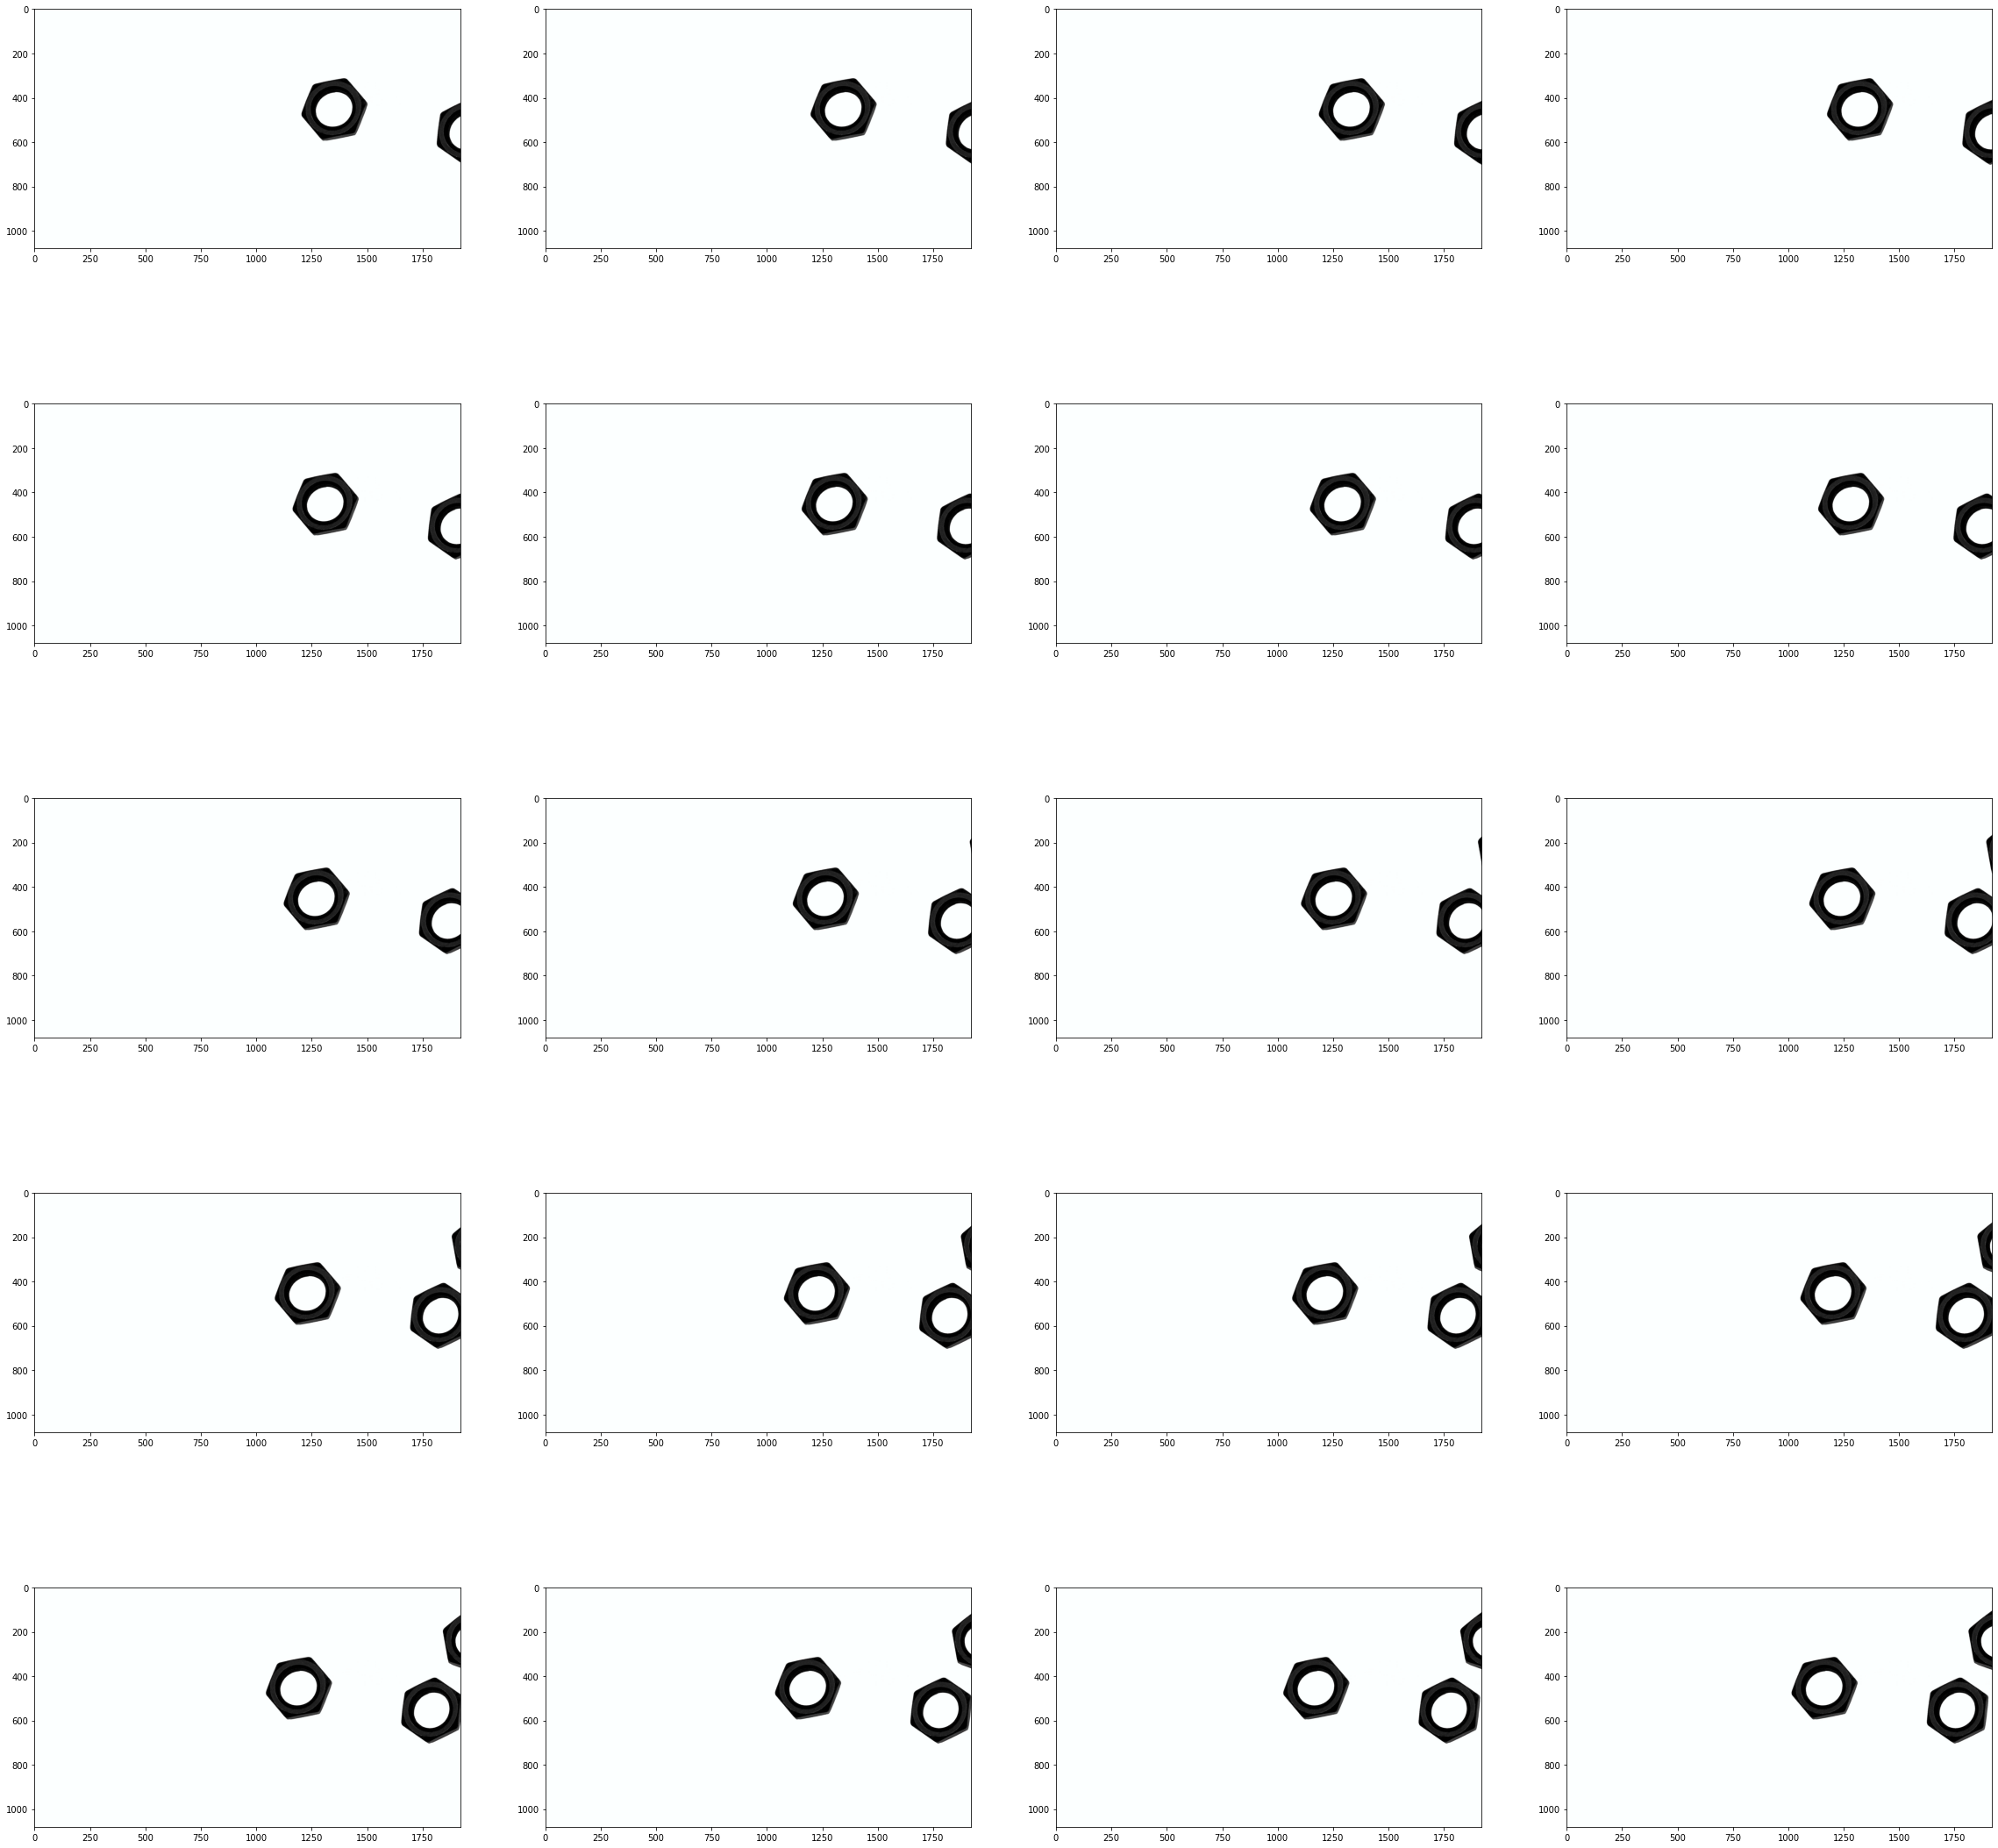

(1080, 1920, 3)


In [19]:
plt.figure(figsize=(40,40))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(frames[20 +i])
plt.show()
print(frames[0].shape)

### 3. Implement a code to detect hexagonal nuts in a moving convey belt. (Grading)<a href="#3.-Implement-a-code-to-detect-hexagonal-nuts-in-a-moving-convey-belt.-(Grading)" class="anchor-link"></a>

## Steps:<a href="#Steps:" class="anchor-link"></a>

1.  Use the above code snippet to access each frame and remember to
    convert the frame into grey scale. Name the variable as `grey`
2.  Call `get_indexed_image` and extract
    `retval, labels, stats, centroids`.
3.  Find contours of all nuts present in a given frame of the belt.
4.  Initiate a 3-D array with zeros to draw contours. Call this
    `im_contours_belt`
5.  Draw each contour. Use `cv.drawContours`. [See
    this](https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)

In [20]:
gray_frames = []
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray_frames.append(cv.cvtColor(frame, cv.COLOR_BGR2GRAY)) # store the grayscale frame images in frames list
    
    if cv.waitKey(1) == ord('q'):  #keyboard interruption
        break
        
cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


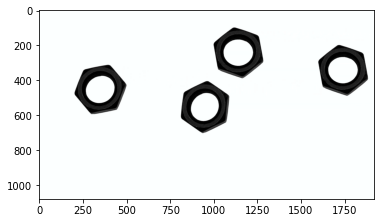

In [21]:
plt.plot(), plt.imshow(frames[120], cmap ='gray')

contour_plots = []
for gray in gray_frames:
    retval, labels, stats, centroids = get_indexed_image(gray)
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,_  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8)
    cont_plot = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 5).astype('uint8')
    contour_plots.append(cont_plot)

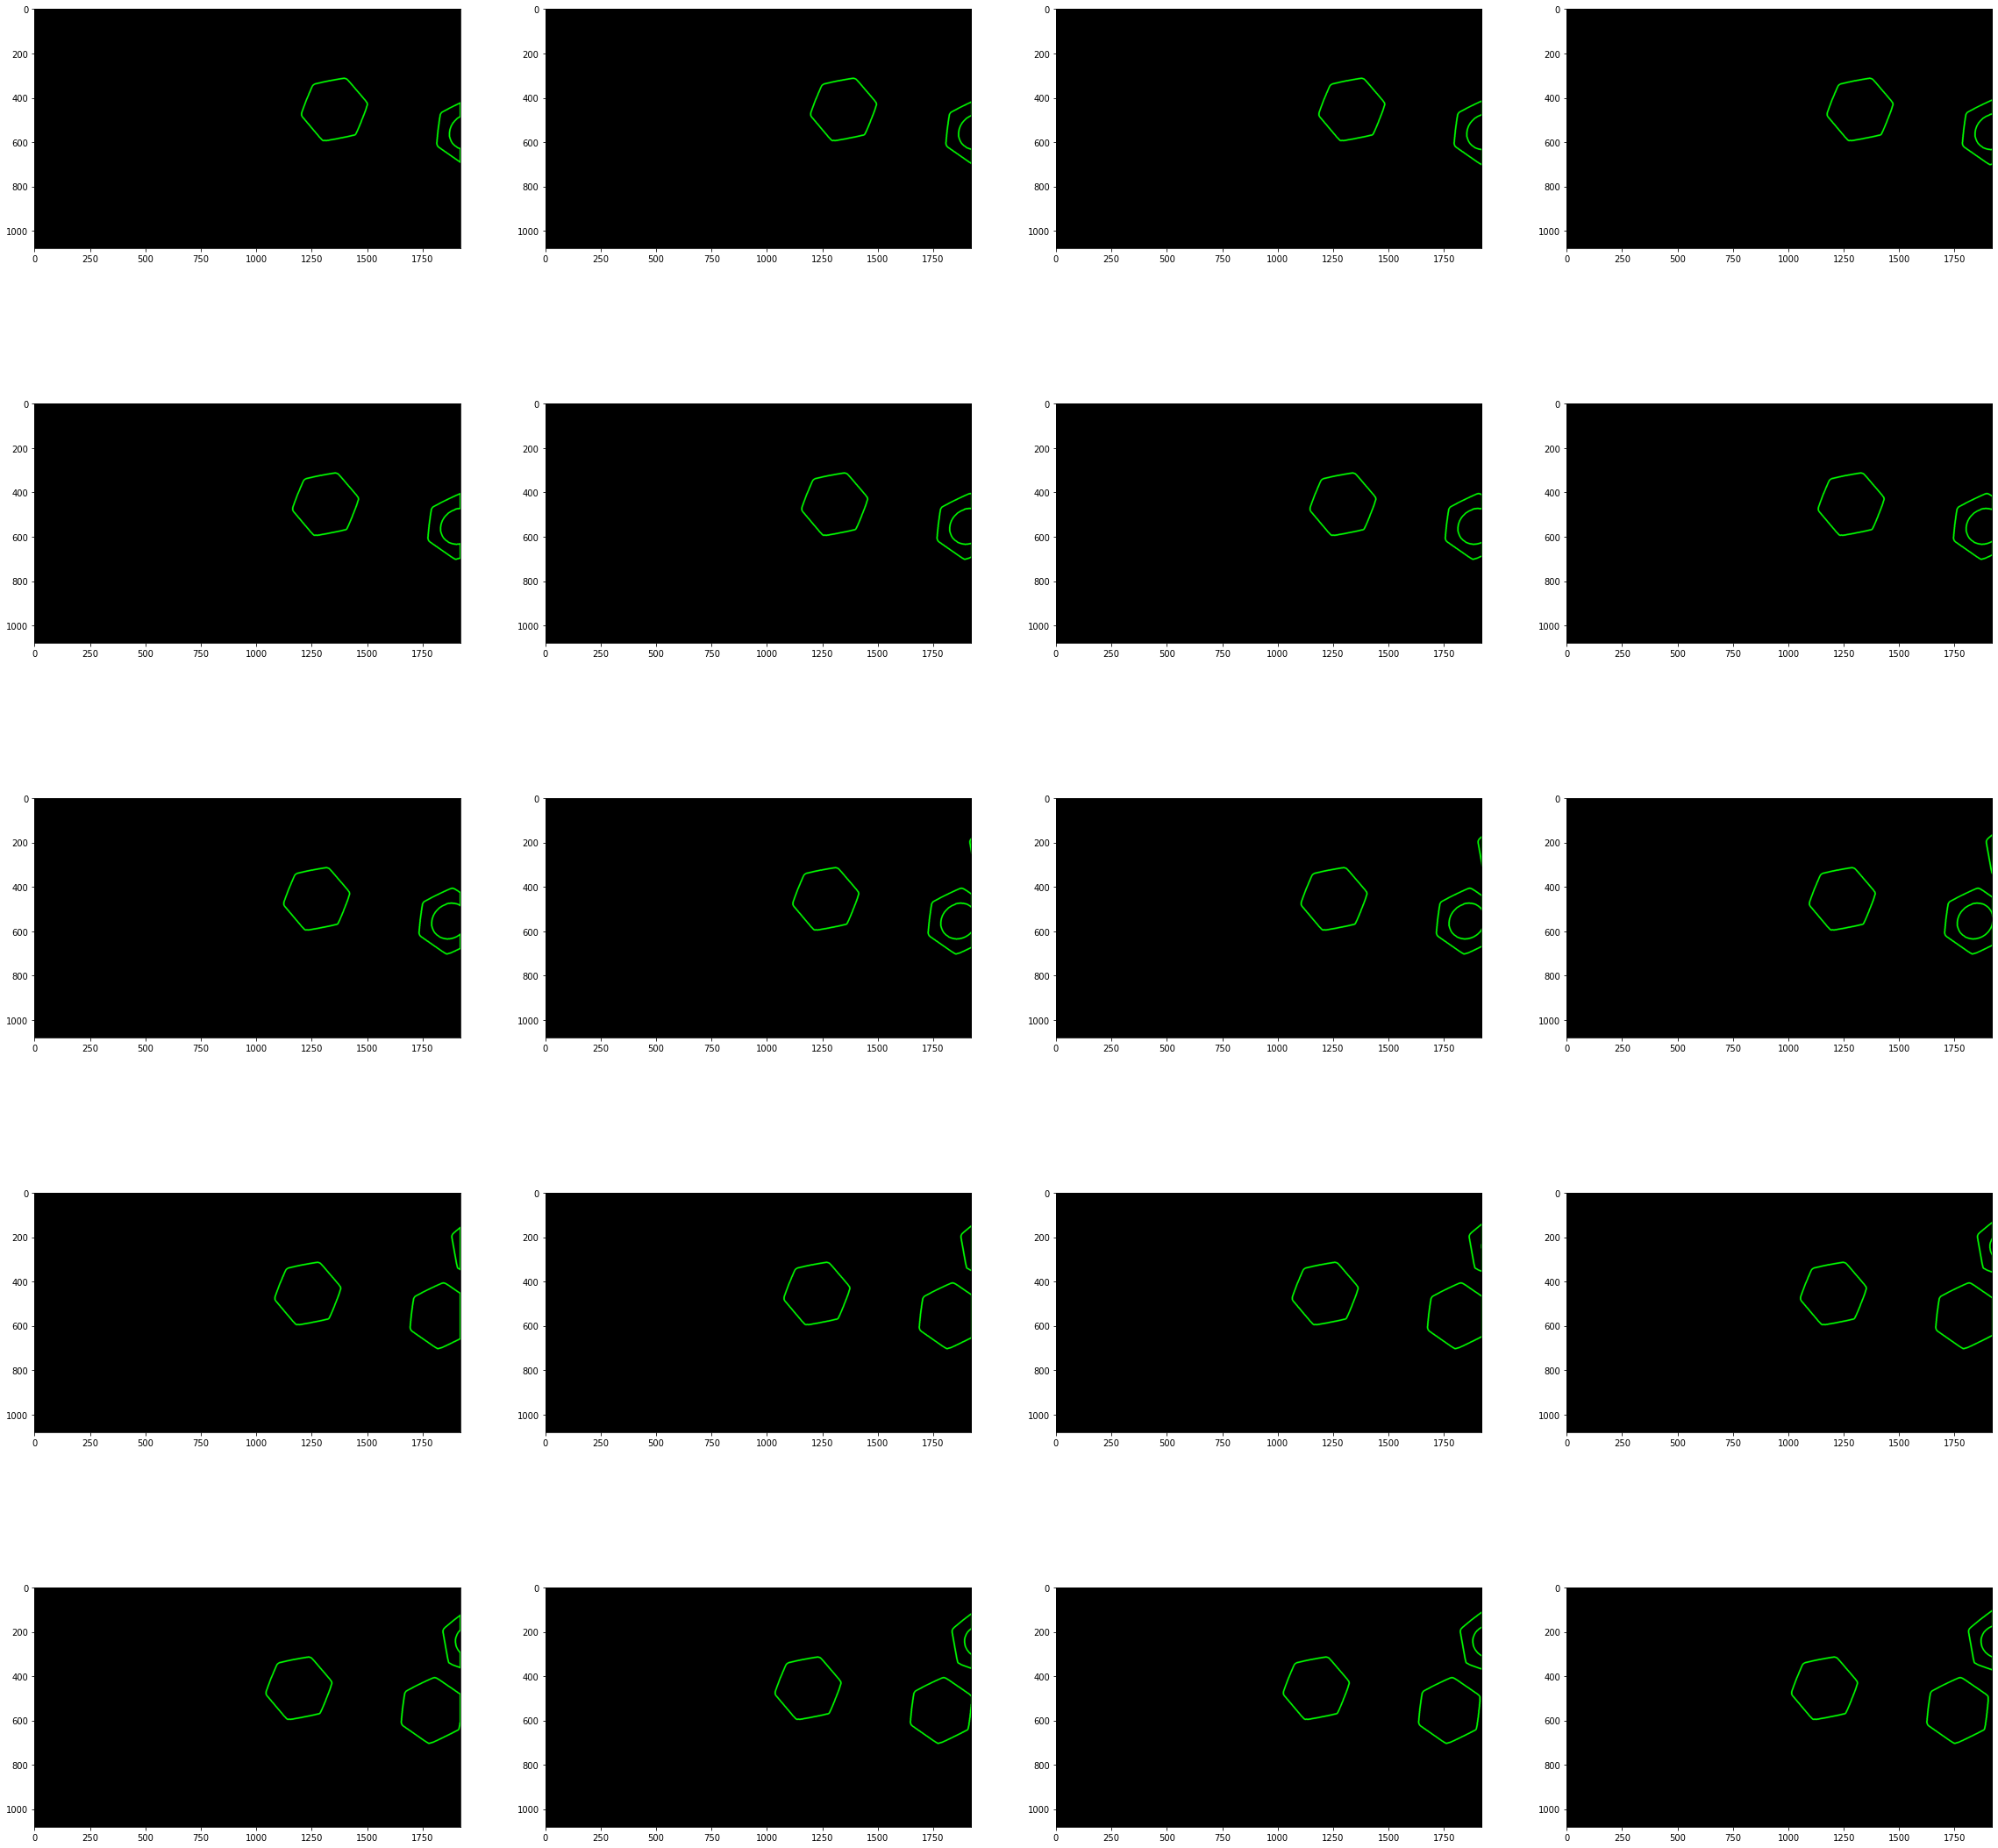

(1080, 1920, 3)


In [22]:
plt.figure(figsize=(40,40))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(contour_plots[20 +i])
plt.show()
print(contour_plots[0].shape)

## Object detection and tracking<a href="#Object-detection-and-tracking" class="anchor-link"></a>

For each contour of the belt frame,

1.  Use `is_new` and `prev_index` functions to track each frame and get
    the indices of each nut.
2.  Write a code to detect and track hexagonal nuts in each frame.
3.  You may refer,
    [annotation](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html)
    to understand how to add texts and labels to each frame.
4.  Output for a random frame would be as follows
    ![](frame_43.PNG)

**Hint**: *If you are thresholding on areas (template and contour) you
can use 500 as the threshold. You can set the matching threshold to be
0.5 and experiment*
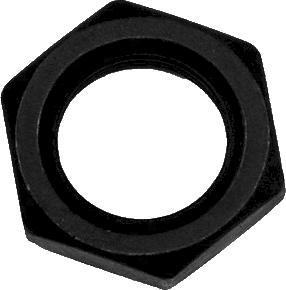

In [23]:
'< Your code goes here >'

'< Your code goes here >'